# Import Data and Train Model


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torchvision.transforms import ToTensor, Lambda

import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd;
import numpy as np
import math

from sklearn.model_selection import train_test_split

C:\Users\loicl\AppData\Local\Temp\ipykernel_18116\2937051277.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd;


## Load Data: Create Dataset


### Load Absence Seizure Data


In [2]:
class AbsenceDataset(Dataset):
    def __init__(self, file_path, transform=None, target_transform=None):
        self.x, self.y = self.data_get(file_path)
        self.n_samples = len(self.x)

        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, idx):
        sample_x, sample_y = self.x[idx], self.y[idx]

        if self.transform:
            sample_x = self.transform(sample_x)

        if self.target_transform:
            sample_y = self.target_transform(sample_y)

        return sample_x.float(), sample_y.float()

    def __len__(self):
        return self.n_samples

    def data_get(self, file_path):
        data = pd.read_csv(file_path)
        x_loaded, y_loaded = [], []
        for index, row in data.iterrows():
            x_loaded.append(np.load(row["data"]))
            y_loaded.append(np.load(row["labels"]))

        continuous_x = np.concatenate(x_loaded, axis=0)
        continuous_y = np.concatenate(y_loaded, axis=0)

        return continuous_x, continuous_y

In [3]:
# Split Data
dataset = AbsenceDataset(
    "processed_data/absence/epochs_files.csv",
    transform=torch.tensor,
    target_transform=torch.tensor,
)

if (int(len(dataset) * 0.7) + int(len(dataset) * 0.2) + int(len(dataset) * 0.1)) != len(
    dataset
):
    train_set, eval_set, test_set = random_split(
        dataset,
        [
            math.ceil(len(dataset) * 0.7),
            int(len(dataset) * 0.2),
            int(len(dataset) * 0.1),
        ],
    )
else:
    train_set, eval_set, test_set = random_split(
        dataset,
        [int(len(dataset) * 0.7), int(len(dataset) * 0.2), int(len(dataset) * 0.1)],
    )

In [4]:
len(dataset)

count = 0
for i, (inputs, labels) in enumerate(train_set):
    if labels == 0:
        count += 1
print(count)

2734


In [5]:
# # Dummy Training Loop
# n_e = 1
# samples = len(dataset)
# n_iter = math.ceil(samples / 4)

# for e in range(n_e):
#     for i, (inputs, labels) in enumerate(train_dataloader):
#         print((inputs.shape))
#         break

In [6]:
count = 0
for i, (inputs, labels) in enumerate(train_set):
    if labels == 0:
        count += 1
print(count)

count = 0
for i, (inputs, labels) in enumerate(train_set):
    if labels == 1:
        count += 1
print(count)

2734
165


In [7]:
train_dataloader = DataLoader(dataset=train_set, batch_size=1, shuffle=True)
eval_dataloader = DataLoader(dataset=eval_set, batch_size=1, shuffle=True)
test_dataloader = DataLoader(dataset=test_set, batch_size=1, shuffle=True)

In [8]:
class AbnormalNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # Input 5 Channels
        self.CNN1 = nn.Conv1d(in_channels=5, out_channels=256, kernel_size=10)
        self.MaxPool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.CNN2 = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=10)
        self.MaxPool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.CNN3 = nn.Conv1d(in_channels=512, out_channels=1024, kernel_size=10)
        self.MaxPool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(119808, 1024)
        self.dropout1 = nn.Dropout(p=0.3)

        self.fc2 = nn.Linear(1024, 1024)
        self.dropout2 = nn.Dropout(p=0.3)

        # Output Layer
        self.output = nn.Linear(in_features=1024, out_features=1)

    def forward(self, x):
        x = F.relu(self.CNN1(x))
        x = self.MaxPool1(x)

        x = F.relu(self.CNN2(x))
        x = self.MaxPool2(x)

        x = F.relu(self.CNN3(x))
        x = self.MaxPool3(x)

        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = self.dropout1(x)

        x = F.relu(self.fc2(x))
        x = self.dropout2(x)

        x = self.output(x)
        return x


# Set device to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = AbnormalNeuralNetwork().to(device)

# Set optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_function = nn.MSELoss()

# Calculate number of parameters in model
n_params = 0
for x in model.parameters():
    n_params += len(torch.flatten(x))
print(f"Number of parameters in model: {n_params:,}")

# Print Model
model

Number of parameters in model: 130,303,233


AbnormalNeuralNetwork(
  (CNN1): Conv1d(5, 256, kernel_size=(10,), stride=(1,))
  (MaxPool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (CNN2): Conv1d(256, 512, kernel_size=(10,), stride=(1,))
  (MaxPool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (CNN3): Conv1d(512, 1024, kernel_size=(10,), stride=(1,))
  (MaxPool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=119808, out_features=1024, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (output): Linear(in_features=1024, out_features=1, bias=True)
)

In [9]:
# Test Model on 1 Batch
for i, (inputs, labels) in enumerate(train_dataloader):
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    print(inputs.shape)
    print(outputs.shape)
    print(labels.shape)
    break

torch.Size([10, 5, 1000])
torch.Size([10, 1])
torch.Size([10])


In [18]:
epochs = 100  # Number of training iterations
losses_train_batch = []
losses_train_epoch = []

for i in range(epochs):
    print(f"Epoch: {i+1}")

    for j, (x_sample, y_sample) in enumerate(train_dataloader):
        # print(f"        Batch: {i+1}")
        x, y = x_sample.to(device), y_sample.to(device)  # Move batch data to GPU
        y = y.unsqueeze(1)

        optimizer.zero_grad()

        y_pred = model(x)  # Input into model forward pass
        # print(y_pred.shape, y.shape)
        loss = loss_function(y_pred, y)  # Calculate the loss

        # Zero gradients, backward pass, update weights
        loss.backward()
        optimizer.step()

        losses_train_batch.append(loss.item())

    losses_train_epoch.append(loss.item())

    print(f"          Epoch Completed: {i+1}")

Epoch: 1
          Epoch Completed: 1
Epoch: 2
          Epoch Completed: 2
Epoch: 3
          Epoch Completed: 3
Epoch: 4
          Epoch Completed: 4
Epoch: 5
          Epoch Completed: 5
Epoch: 6
          Epoch Completed: 6
Epoch: 7
          Epoch Completed: 7
Epoch: 8
          Epoch Completed: 8
Epoch: 9
          Epoch Completed: 9
Epoch: 10
          Epoch Completed: 10
Epoch: 11
          Epoch Completed: 11
Epoch: 12
          Epoch Completed: 12
Epoch: 13
          Epoch Completed: 13
Epoch: 14
          Epoch Completed: 14
Epoch: 15
          Epoch Completed: 15
Epoch: 16
          Epoch Completed: 16
Epoch: 17
          Epoch Completed: 17
Epoch: 18
          Epoch Completed: 18
Epoch: 19
          Epoch Completed: 19
Epoch: 20
          Epoch Completed: 20
Epoch: 21
          Epoch Completed: 21
Epoch: 22
          Epoch Completed: 22
Epoch: 23
          Epoch Completed: 23
Epoch: 24
          Epoch Completed: 24
Epoch: 25
          Epoch Completed: 25
Epoch: 26
        

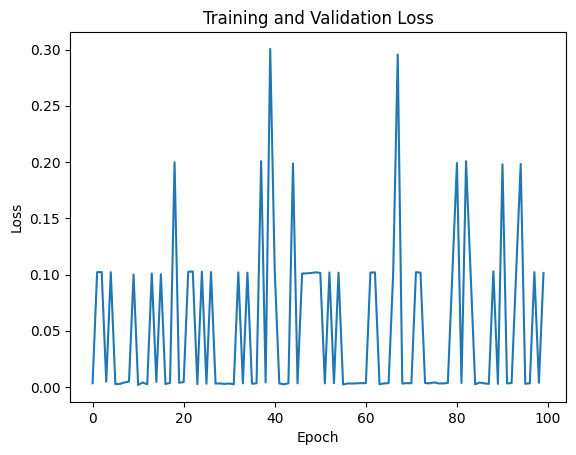

In [21]:
# Plot losses
plt.plot(range(len(losses_train_epoch)), losses_train_epoch, label="Training Loss")


plt.title("Training and Validation Loss")

plt.xlabel("Epoch")

plt.ylabel("Loss")


plt.show()